In [37]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [38]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [39]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [40]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [41]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [42]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [43]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [44]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.94602242 0.00146136]
The function value of pqbest:		1.4650080497667552
Algorithm running time:			3.2379133701324463 s


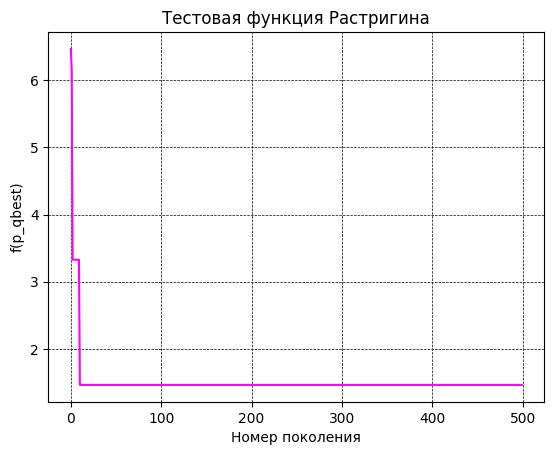

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.04105769 0.97718959]
The function value of pqbest:		1.3900248131195454
Algorithm running time:			0.020004987716674805 s


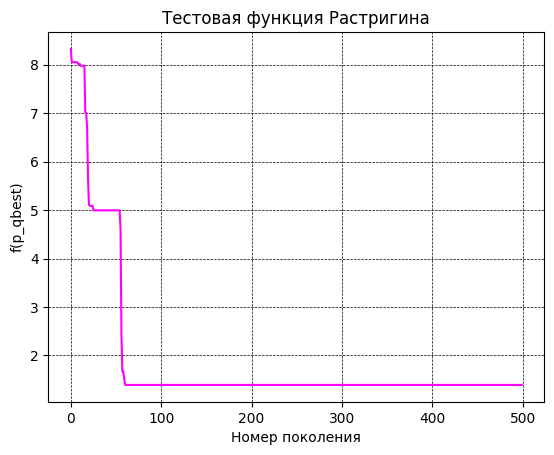

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.00346688 -1.0054165 ]
The function value of pqbest:		1.0190374075644328
Algorithm running time:			0.022005558013916016 s


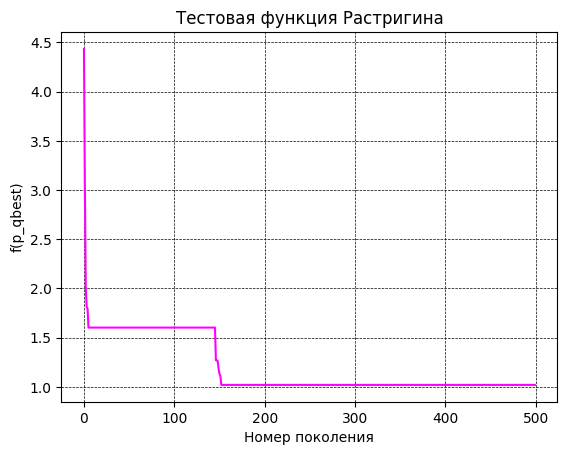

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.9150791  -1.09126832]
The function value of pqbest:		5.017975937788005
Algorithm running time:			0.018994808197021484 s


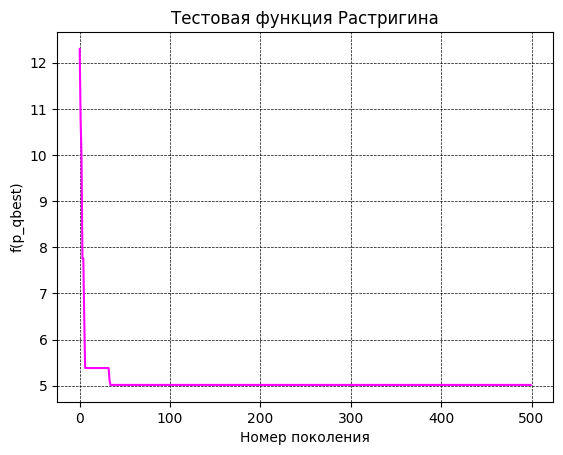

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.98392656 -1.94430599]
The function value of pqbest:		5.4054439010538395
Algorithm running time:			0.020010948181152344 s


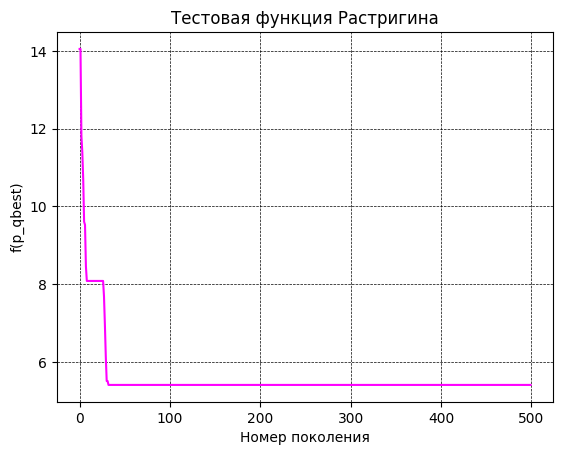

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 1.05081444 -0.00276559]
The function value of pqbest:		1.611100795830751
Algorithm running time:			0.02100539207458496 s


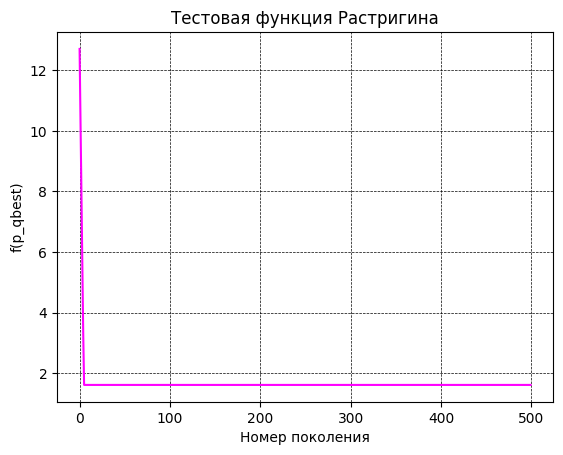

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[1.01054399 1.04483687]
The function value of pqbest:		2.529028920464796
Algorithm running time:			0.02001643180847168 s


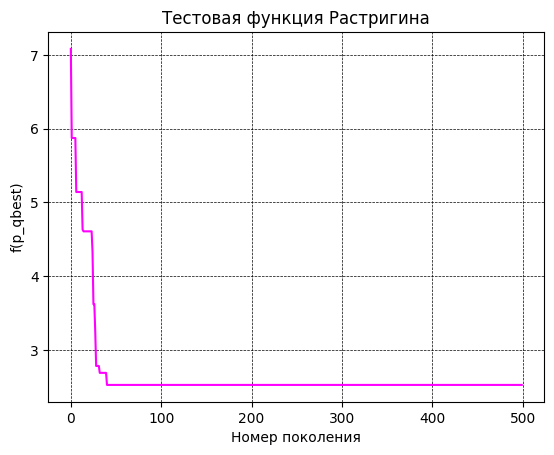

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.00405175  1.00448416]
The function value of pqbest:		1.0162140151399512
Algorithm running time:			0.020586729049682617 s


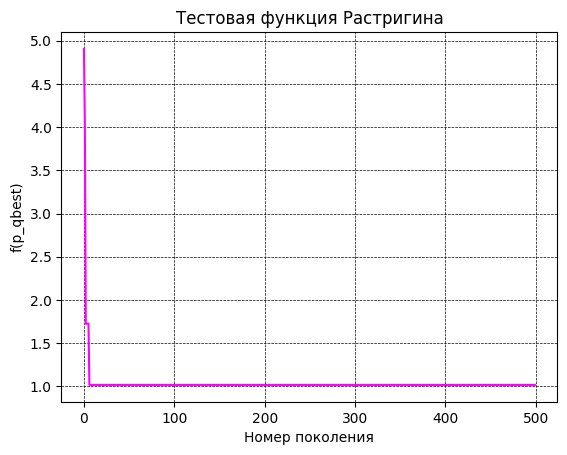

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 1.13725894 -0.00168176]
The function value of pqbest:		4.787928704804097
Algorithm running time:			0.018590450286865234 s


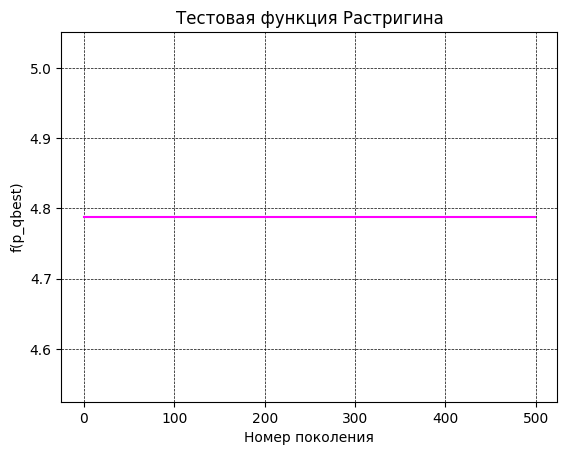

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[1.95287158 0.05683527]
The function value of pqbest:		4.883046721681492
Algorithm running time:			0.01900458335876465 s


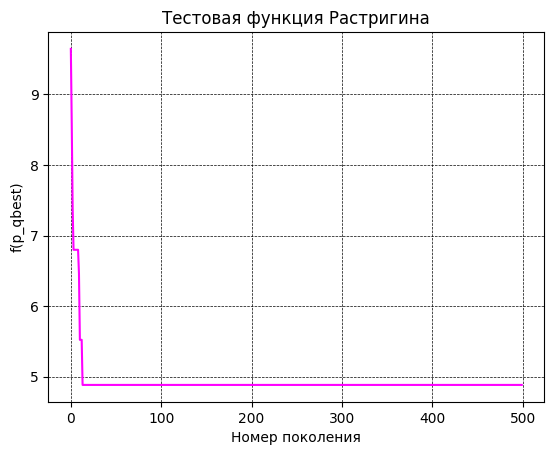

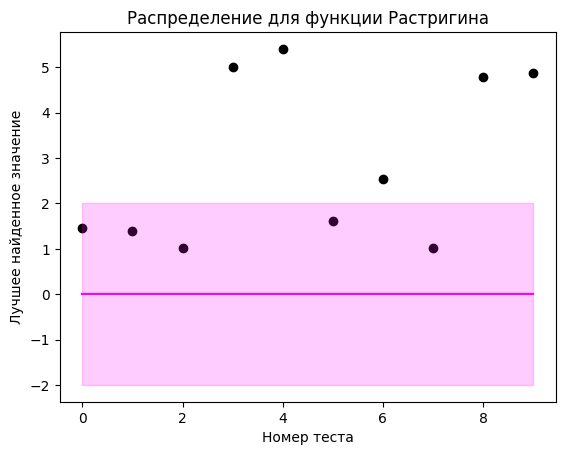

In [45]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [46]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [47]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.00119188 -0.00735881]
The function value of pqbest:		0.022564233247791776
Algorithm running time:			2.848202705383301 s


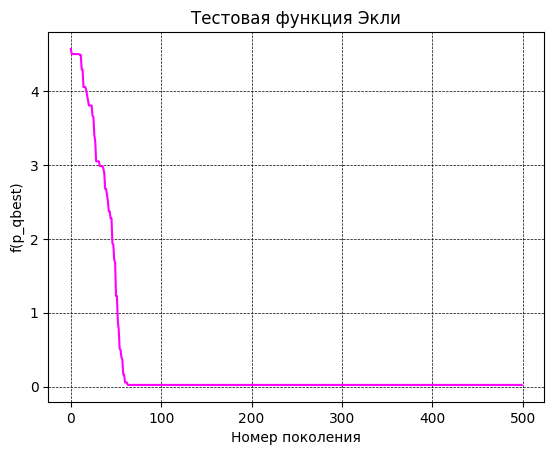

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.19818538 -0.08828429]
The function value of pqbest:		1.527721079770945
Algorithm running time:			0.02601456642150879 s


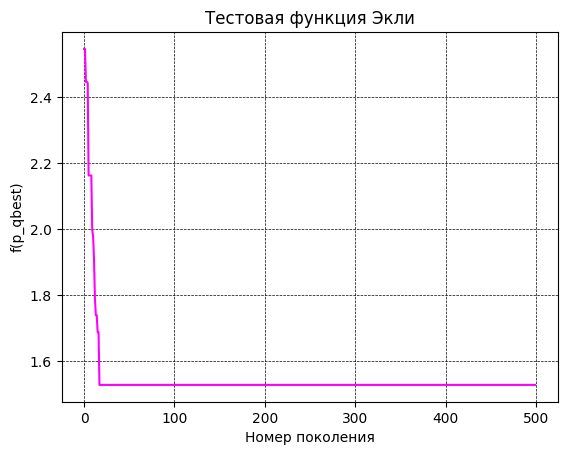

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.17149335  0.07219906]
The function value of pqbest:		1.2515857863241528
Algorithm running time:			0.02201223373413086 s


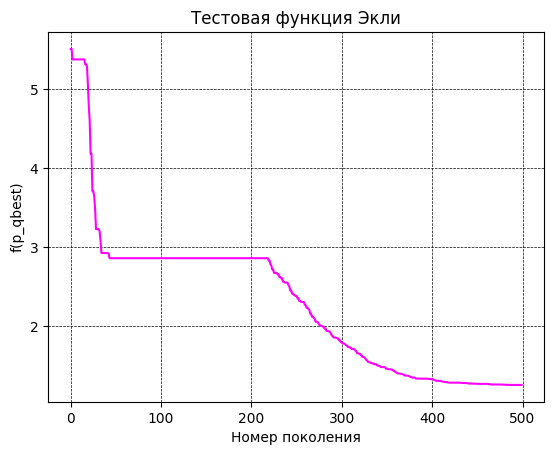

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.95699212  0.00096962]
The function value of pqbest:		2.580510512679872
Algorithm running time:			0.022006511688232422 s


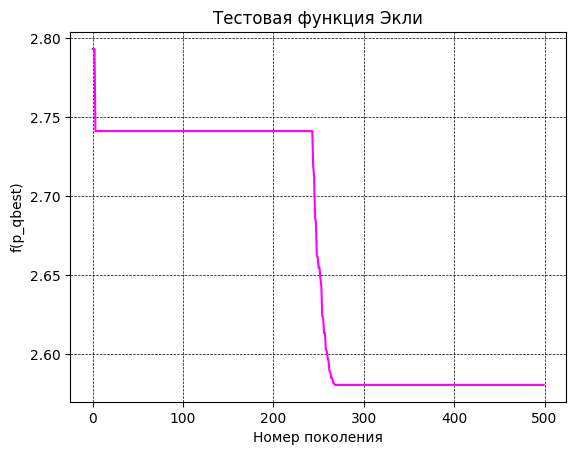

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.11423335 -1.14340157]
The function value of pqbest:		3.7302263557311477
Algorithm running time:			0.021004199981689453 s


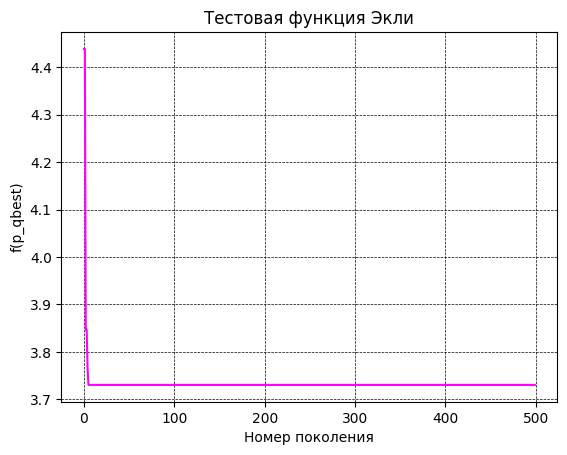

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.01450225  0.00015431]
The function value of pqbest:		0.04661216239015786
Algorithm running time:			0.021004199981689453 s


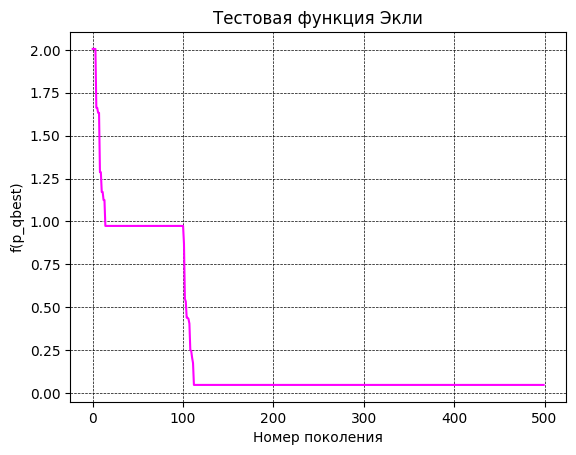

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.15490182 -0.26159576]
The function value of pqbest:		2.282457828220526
Algorithm running time:			0.02100515365600586 s


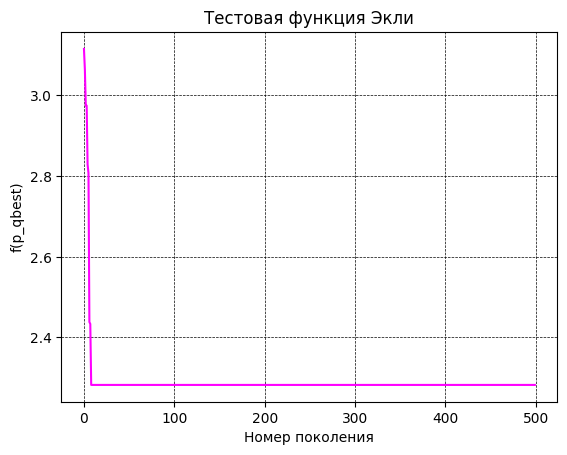

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.01239479  0.03280085]
The function value of pqbest:		0.13161620312984823
Algorithm running time:			0.021541833877563477 s


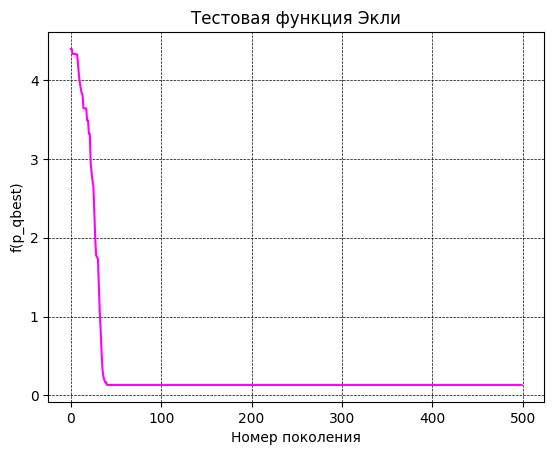

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.00175779 -0.96393551]
The function value of pqbest:		2.5833611414353648
Algorithm running time:			0.023998260498046875 s


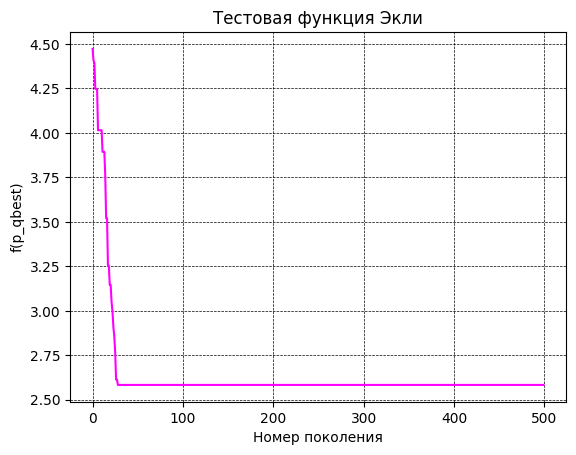

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.30631271 -0.1659955 ]
The function value of pqbest:		2.5980705791812113
Algorithm running time:			0.024018287658691406 s


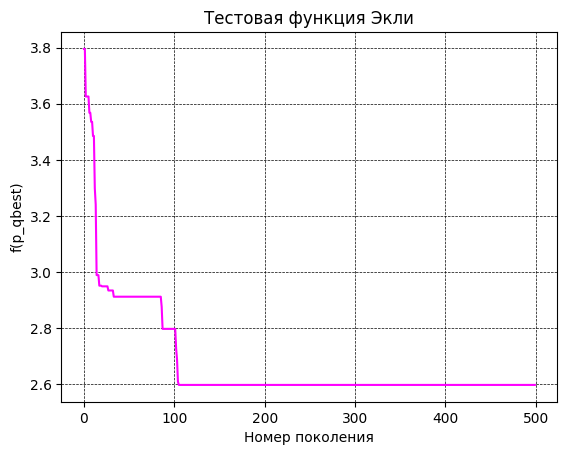

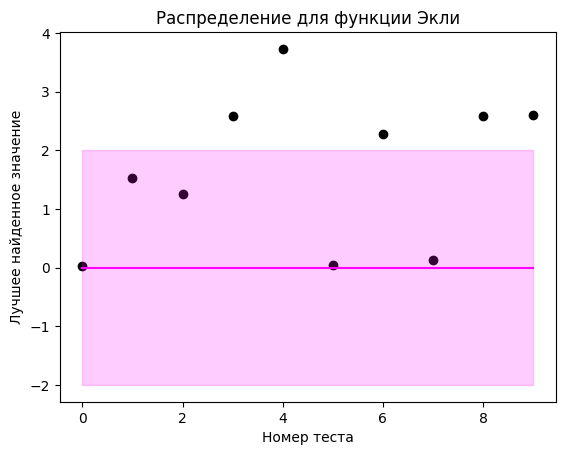

In [48]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [49]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [50]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.85186778  0.17852418]
The function value of pqbest:		0.7575495939330807
Algorithm running time:			2.8932933807373047 s


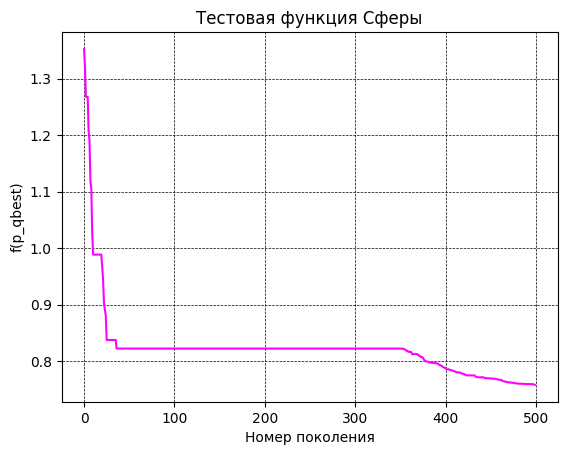

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.00236855 -0.00135513]
The function value of pqbest:		7.446424238735763e-06
Algorithm running time:			0.0180361270904541 s


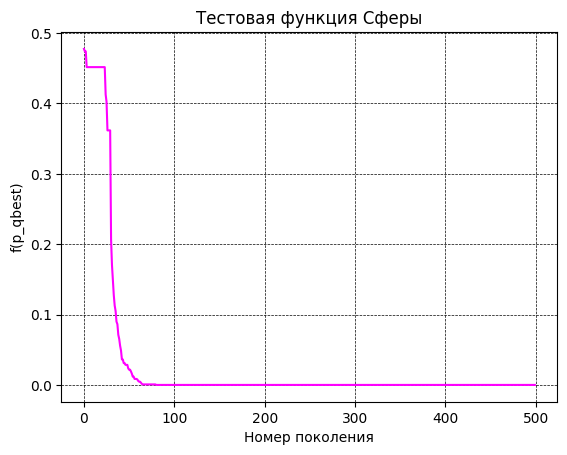

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.17045667 -0.0021101 ]
The function value of pqbest:		0.029059927303041827
Algorithm running time:			0.01700305938720703 s


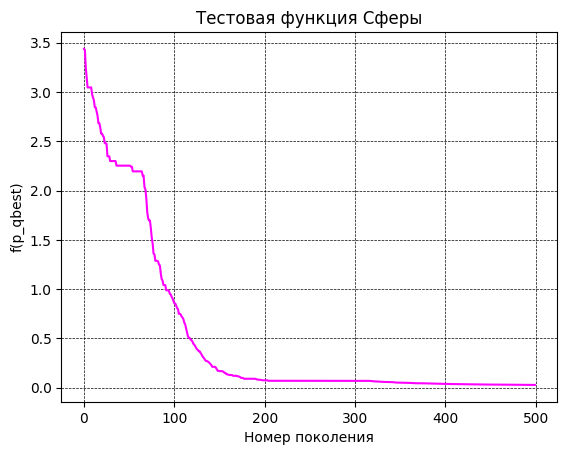

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.01719581 0.24253072]
The function value of pqbest:		0.05911684829318959
Algorithm running time:			0.017003536224365234 s


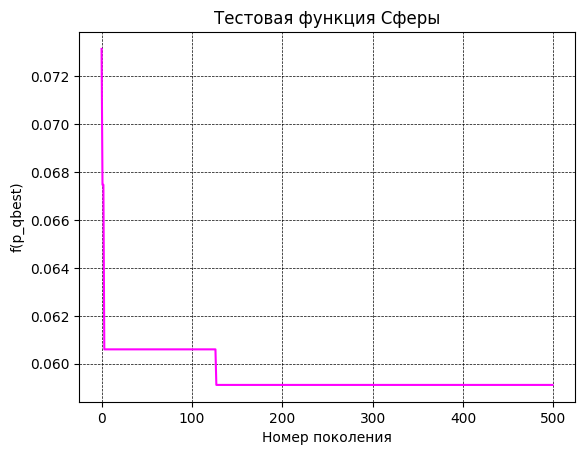

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.01804441 0.07477978]
The function value of pqbest:		0.005917617042787697
Algorithm running time:			0.016989707946777344 s


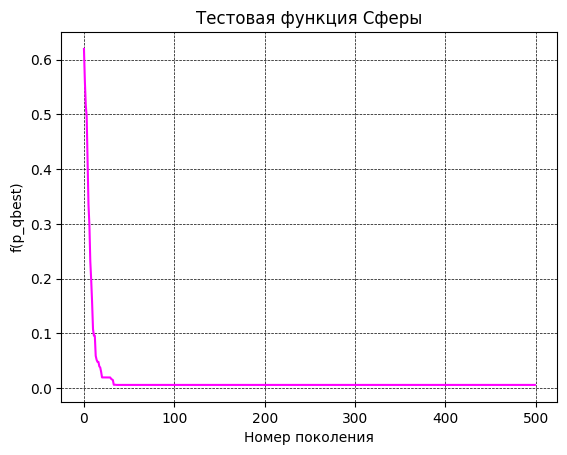

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.38931051 -0.3710771 ]
The function value of pqbest:		0.2892608825507371
Algorithm running time:			0.01900339126586914 s


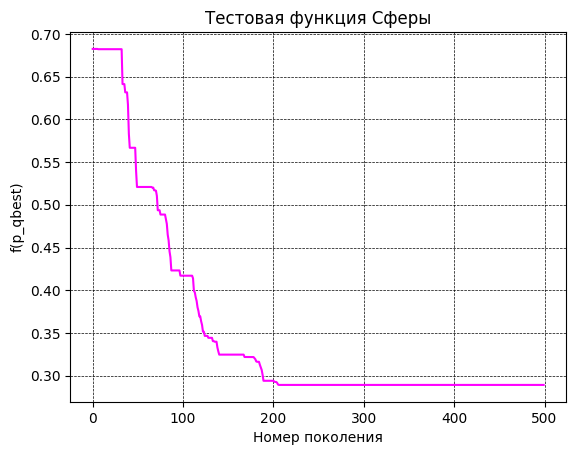

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.95778045 -0.61062502]
The function value of pqbest:		1.290206311699419
Algorithm running time:			0.018000364303588867 s


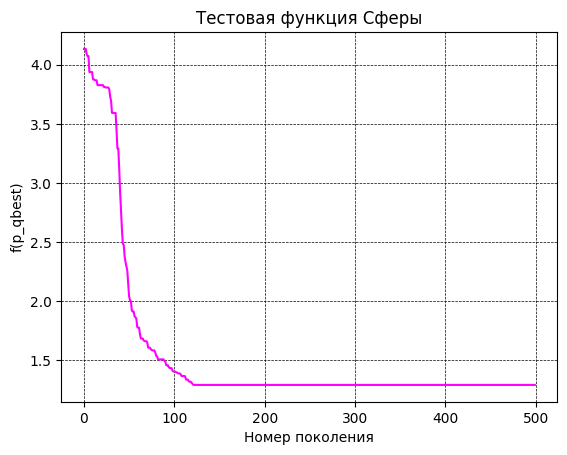

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.78930334  0.06848616]
The function value of pqbest:		0.6276901212773678
Algorithm running time:			0.01901555061340332 s


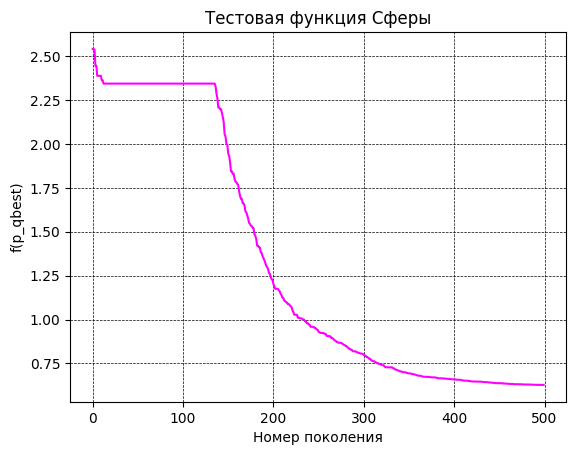

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.28166589  0.29044405]
The function value of pqbest:		0.16369341717366798
Algorithm running time:			0.021417617797851562 s


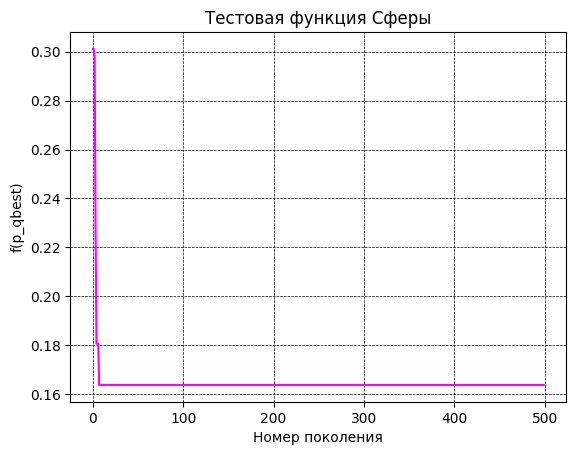

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.05180306 0.32642346]
The function value of pqbest:		0.10923583235240632
Algorithm running time:			0.018571853637695312 s


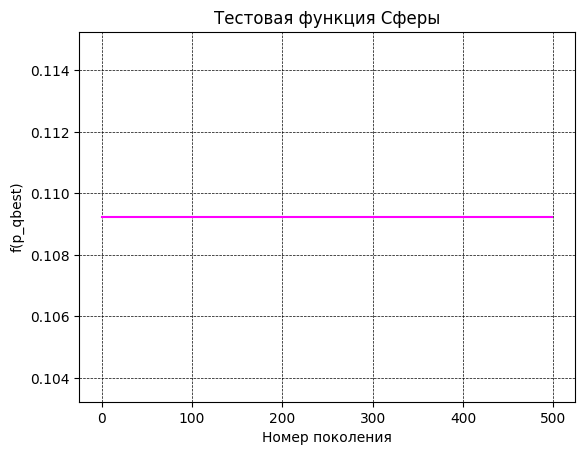

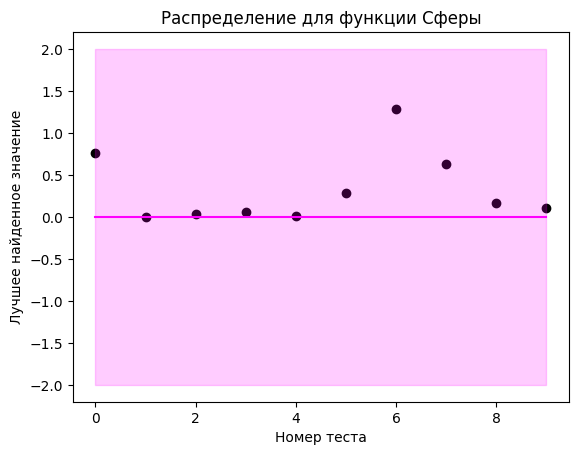

In [51]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [52]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [53]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.85875204 0.73486387]
The function value of pqbest:		0.0206224152718358
Algorithm running time:			2.9971237182617188 s


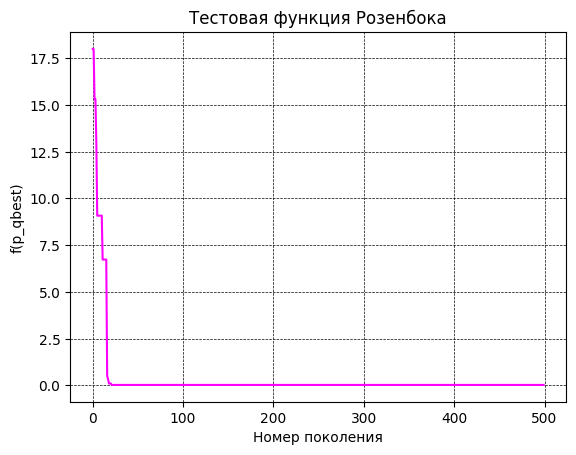

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[1.12620796 1.25982835]
The function value of pqbest:		0.023180719692261875
Algorithm running time:			0.018007993698120117 s


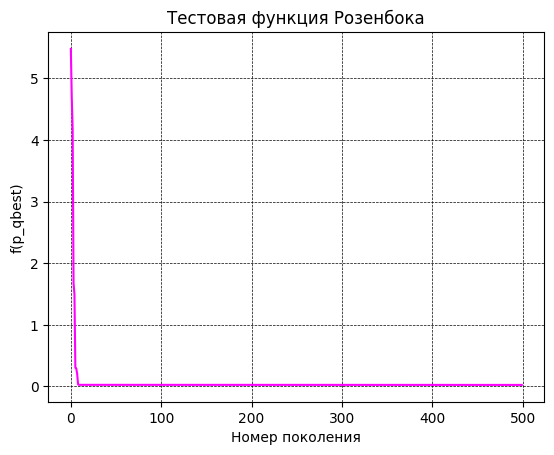

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 3.32065533 11.04924271]
The function value of pqbest:		5.436025142020081
Algorithm running time:			0.018011808395385742 s


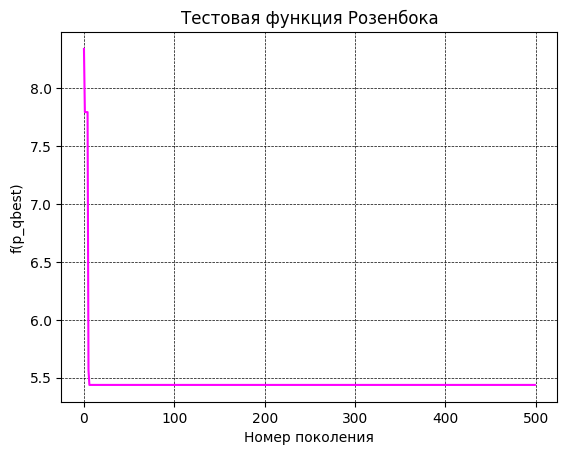

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.05553726  0.00515642]
The function value of pqbest:		1.1145882391259223
Algorithm running time:			0.017015457153320312 s


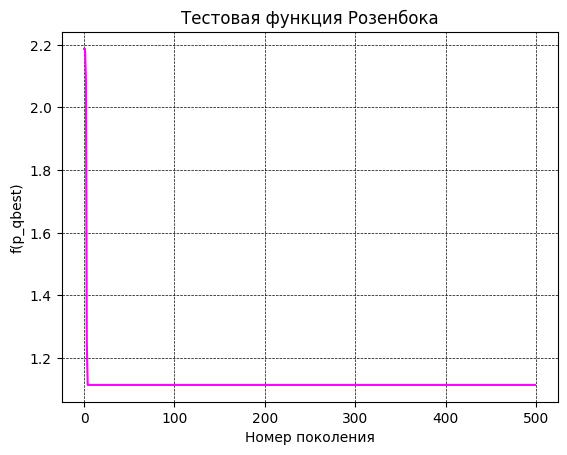

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.53983657 2.38401419]
The function value of pqbest:		0.3081097555103712
Algorithm running time:			0.019004106521606445 s


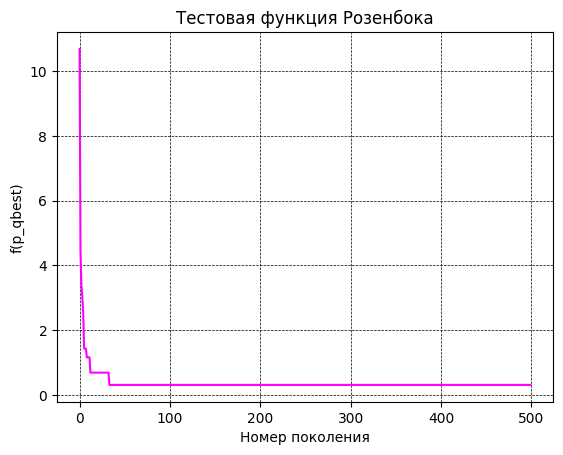

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.57498307 2.53573333]
The function value of pqbest:		0.6348865627174383
Algorithm running time:			0.018004655838012695 s


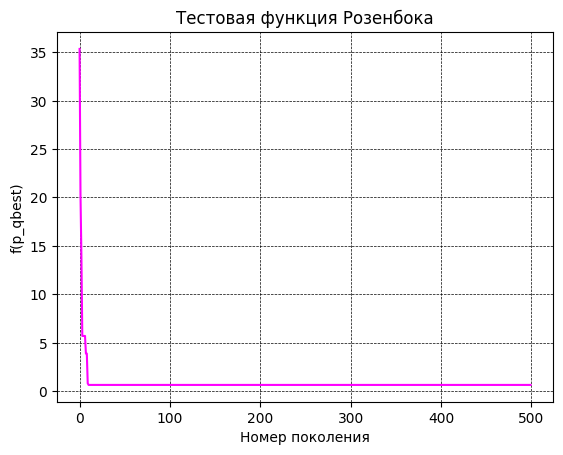

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.9128086  8.47497745]
The function value of pqbest:		3.6678171757220666
Algorithm running time:			0.017991304397583008 s


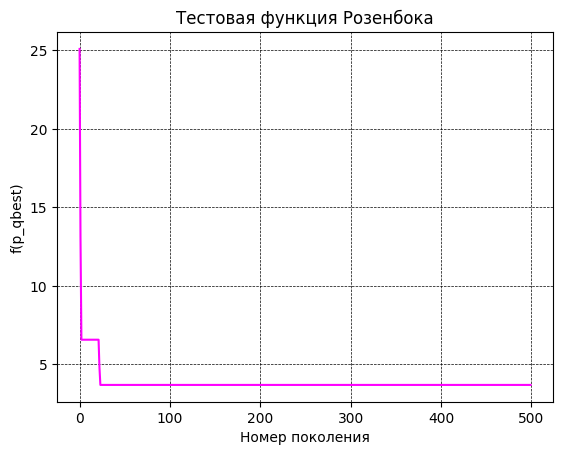

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[1.64551813 2.71799185]
The function value of pqbest:		0.4272243971801615
Algorithm running time:			0.019004106521606445 s


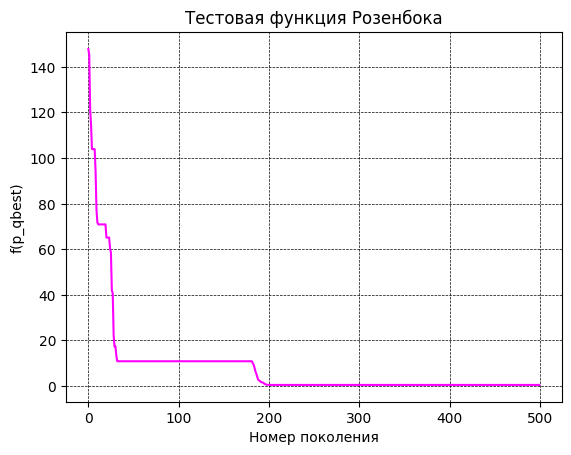

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.71914395 7.29744506]
The function value of pqbest:		3.882800596536582
Algorithm running time:			0.017998218536376953 s


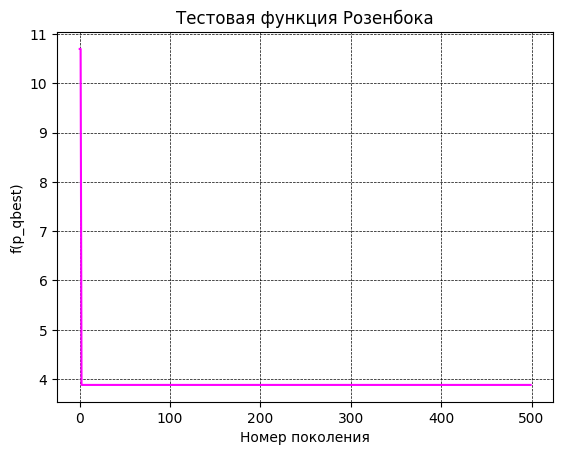

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[2.47008641 6.12537485]
The function value of pqbest:		2.2189844910040013
Algorithm running time:			0.019008874893188477 s


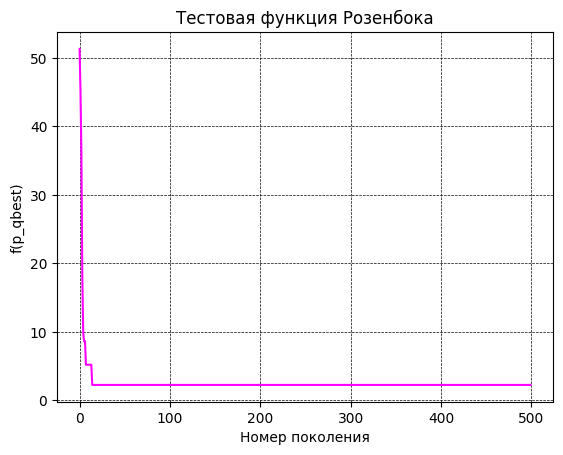

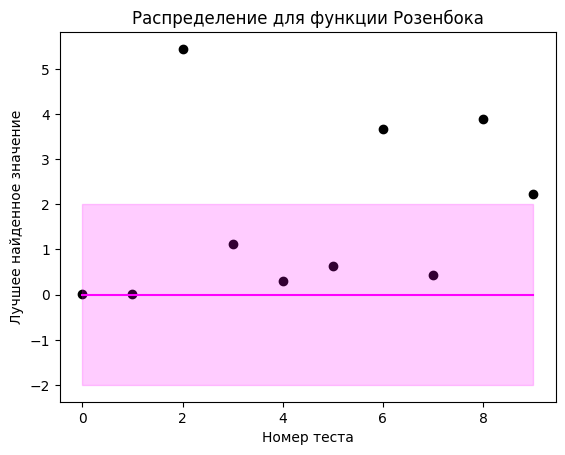

In [54]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [55]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [56]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[3.01658408 0.50331825]
The function value of pqbest:		5.7042407033141255e-05
Algorithm running time:			2.9633500576019287 s


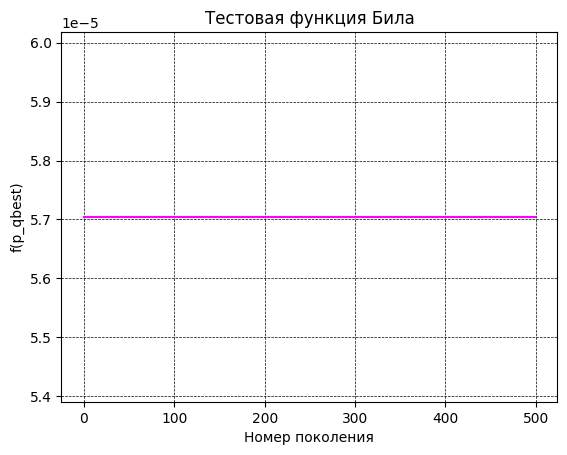

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[5.0372554  0.75571165]
The function value of pqbest:		0.13738029983340722
Algorithm running time:			0.019016504287719727 s


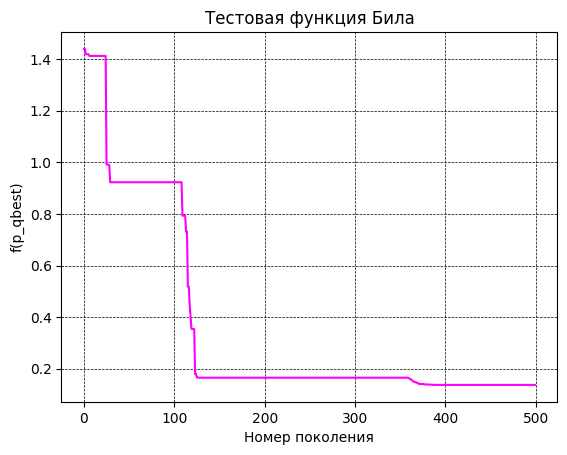

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[3.0012455  0.50264758]
The function value of pqbest:		0.00012711553173070668
Algorithm running time:			0.020012617111206055 s


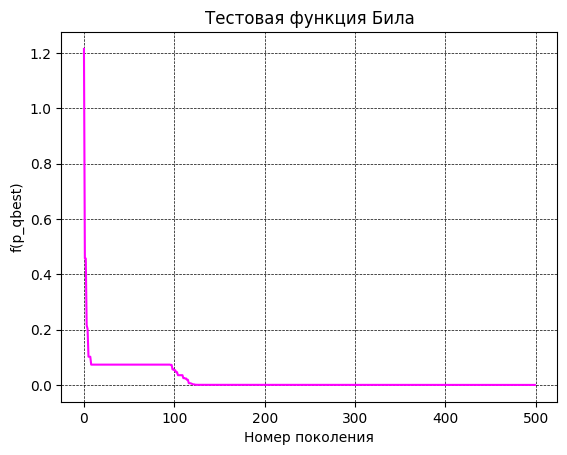

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[3.29365742 0.56253379]
The function value of pqbest:		0.01028081487471094
Algorithm running time:			0.018002748489379883 s


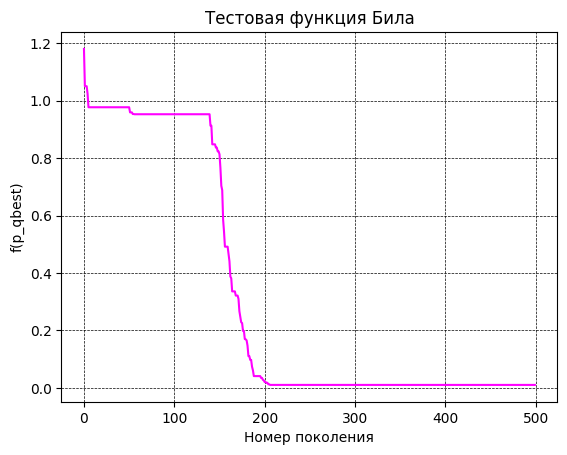

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[3.0458916  0.51172194]
The function value of pqbest:		0.00032809381083198424
Algorithm running time:			0.018059492111206055 s


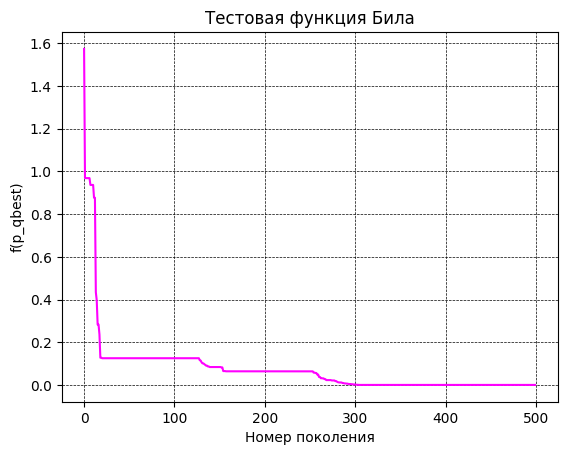

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[3.19064533 0.54402825]
The function value of pqbest:		0.004746815341331654
Algorithm running time:			0.02008056640625 s


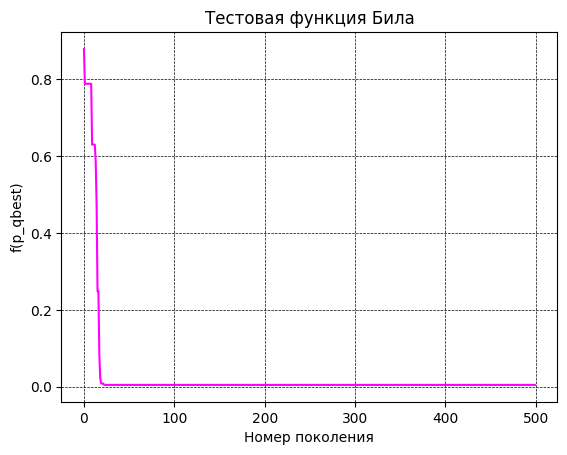

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[3.01134315 0.5018399 ]
The function value of pqbest:		4.187318206992009e-05
Algorithm running time:			0.019010305404663086 s


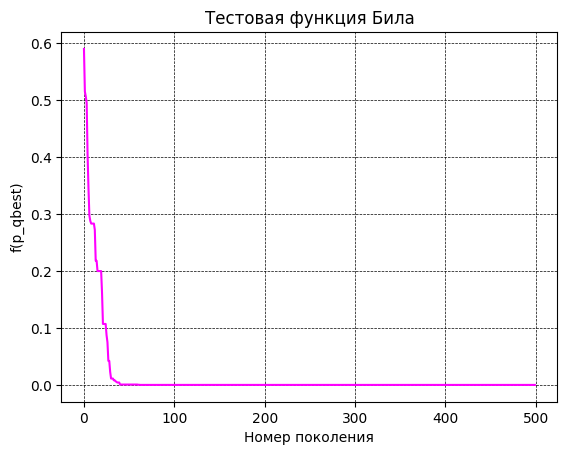

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[2.71237622 0.4582748 ]
The function value of pqbest:		0.042608021404408766
Algorithm running time:			0.01901531219482422 s


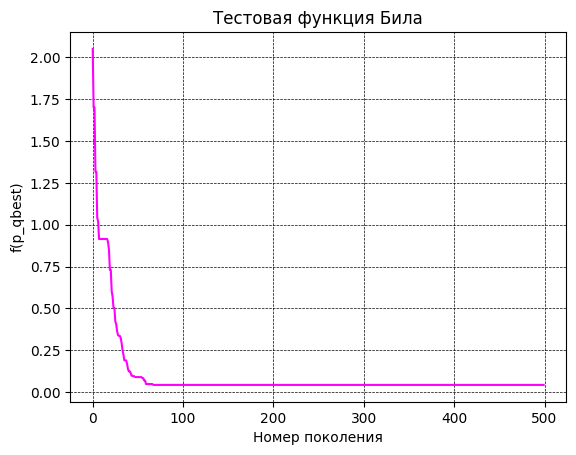

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.93065326 0.49679207]
The function value of pqbest:		0.005337491088278498
Algorithm running time:			0.021004915237426758 s


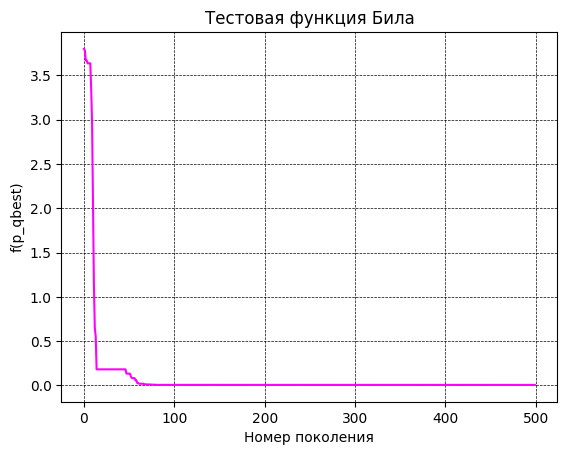

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[3.02589315 0.50527398]
The function value of pqbest:		0.00013201086220606507
Algorithm running time:			0.018010854721069336 s


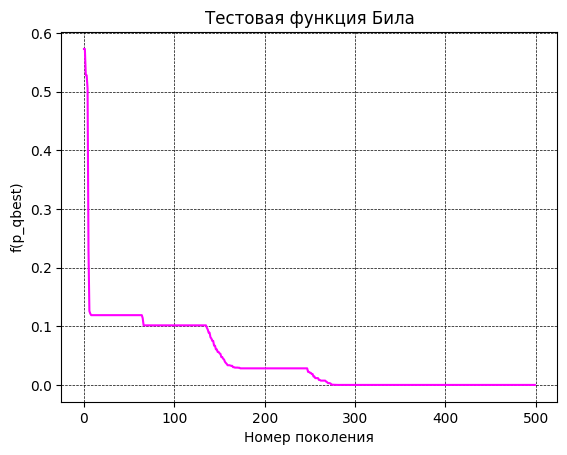

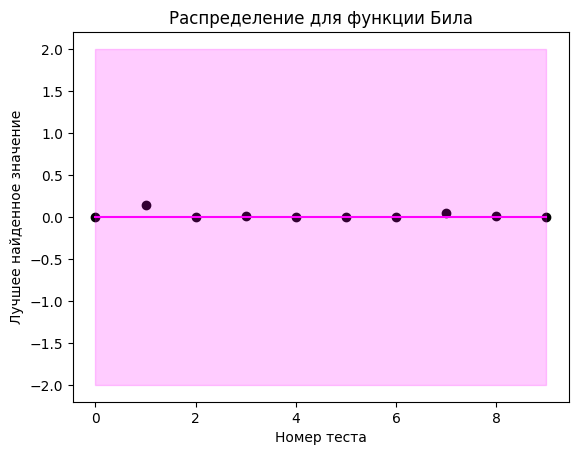

In [57]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [58]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [59]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.02381308 -1.01841367]
The function value of pqbest:		3.1993550217897604
Algorithm running time:			3.3312325477600098 s


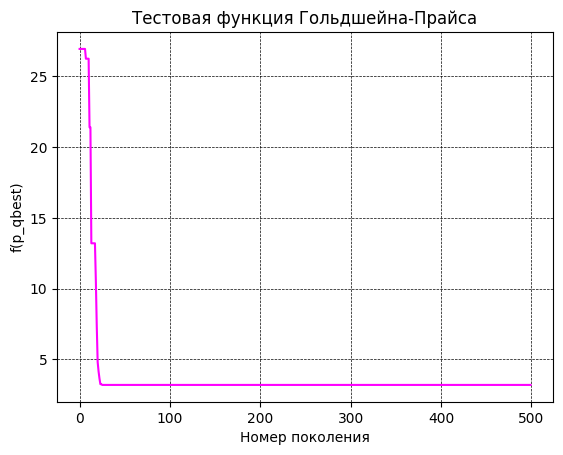

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.05823694 -0.97901234]
The function value of pqbest:		4.253013566828618
Algorithm running time:			0.018996477127075195 s


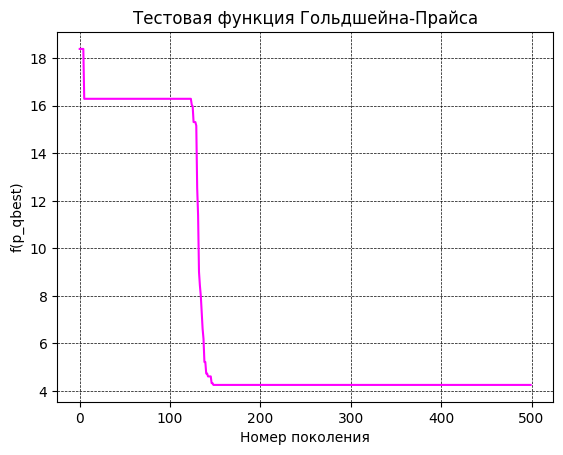

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.0189279  -1.03490782]
The function value of pqbest:		3.8262084646147625
Algorithm running time:			0.019992828369140625 s


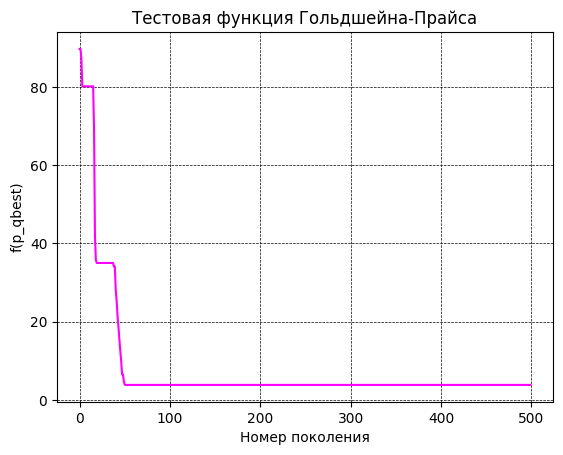

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.0524722  -1.00764766]
The function value of pqbest:		3.665785013442667
Algorithm running time:			0.01799321174621582 s


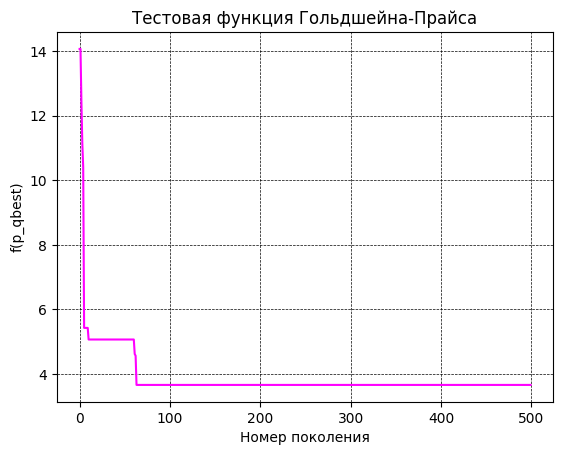

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.12570744 -0.91920511]
The function value of pqbest:		7.100453476261886
Algorithm running time:			0.018158435821533203 s


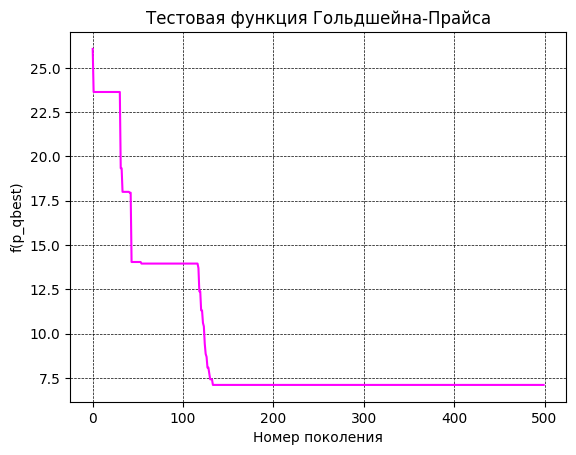

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.00909025 -1.01206081]
The function value of pqbest:		3.0608607492187008
Algorithm running time:			0.01800394058227539 s


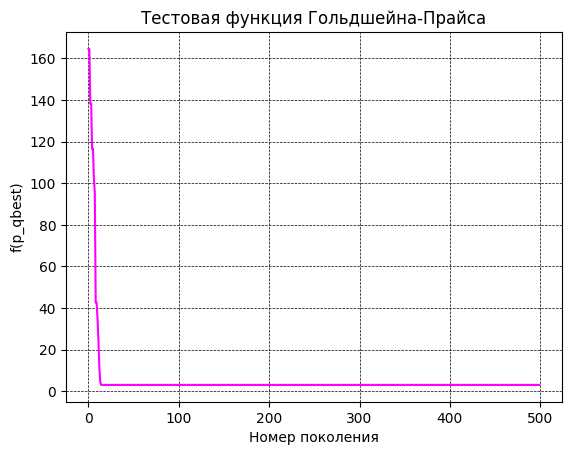

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.03816317 -1.04700728]
The function value of pqbest:		4.019852924297532
Algorithm running time:			0.019004106521606445 s


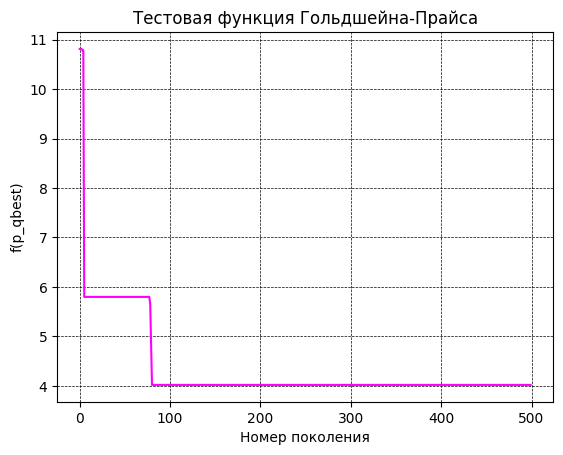

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.07297349 -0.91655104]
The function value of pqbest:		6.0864999875707175
Algorithm running time:			0.018997907638549805 s


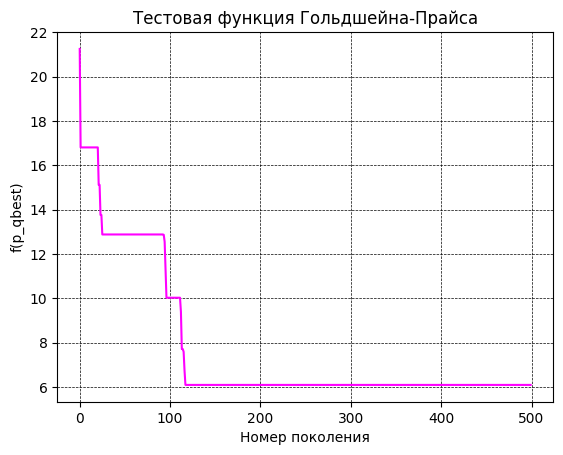

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.00339536 -1.00183041]
The function value of pqbest:		3.0057323327654215
Algorithm running time:			0.01799631118774414 s


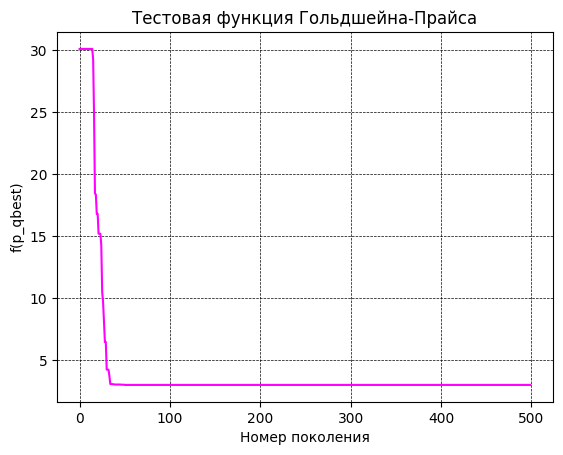

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.02346953 -0.99127417]
The function value of pqbest:		3.2098520798142207
Algorithm running time:			0.019006967544555664 s


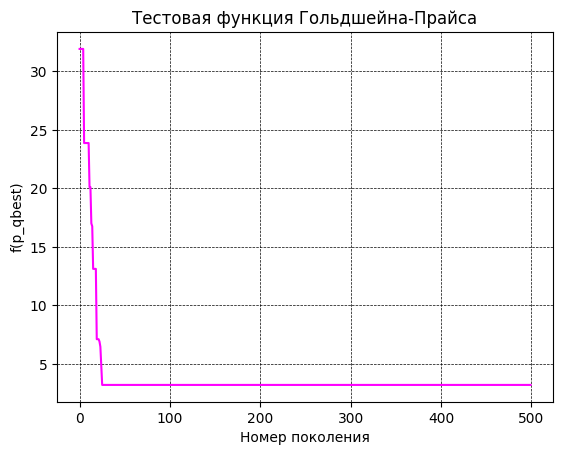

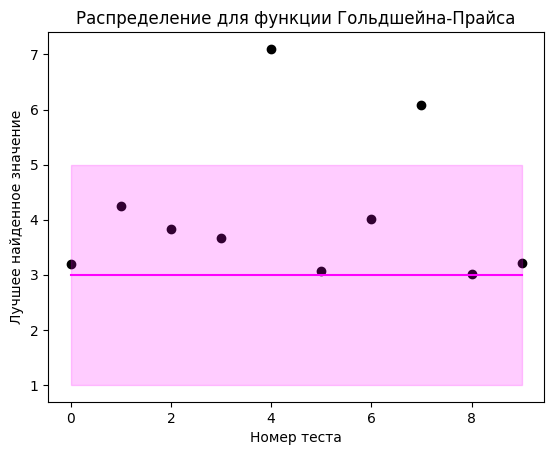

In [60]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3)

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [61]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [62]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[1.86944344 1.88201721]
The function value of pqbest:		0.38686506734613385
Algorithm running time:			2.749027967453003 s


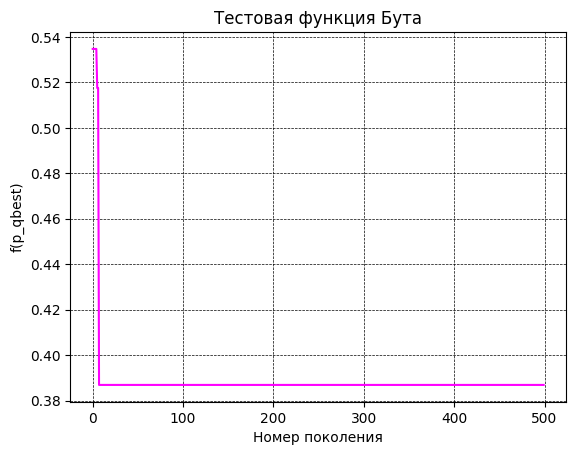

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[1.27338666 2.78192173]
The function value of pqbest:		0.1152525278157646
Algorithm running time:			0.01810908317565918 s


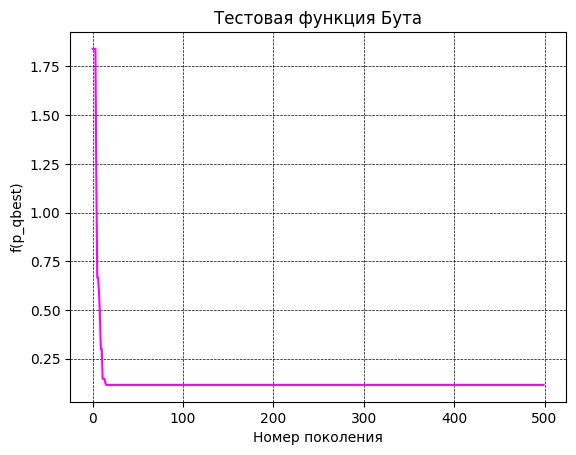

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.80162931 4.95639423]
The function value of pqbest:		3.3281555508148206
Algorithm running time:			0.018004655838012695 s


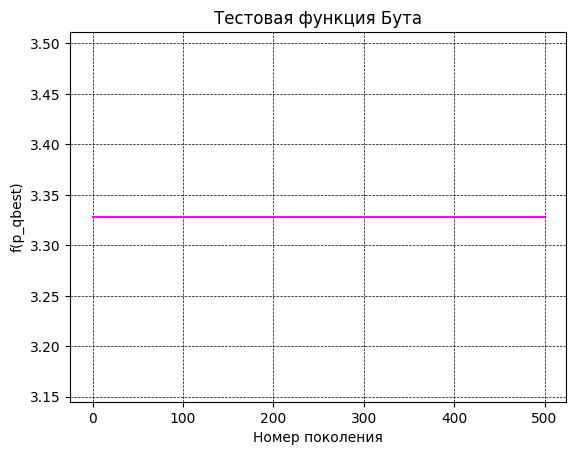

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2.11066585 1.60068897]
The function value of pqbest:		0.734747988231248
Algorithm running time:			0.017992496490478516 s


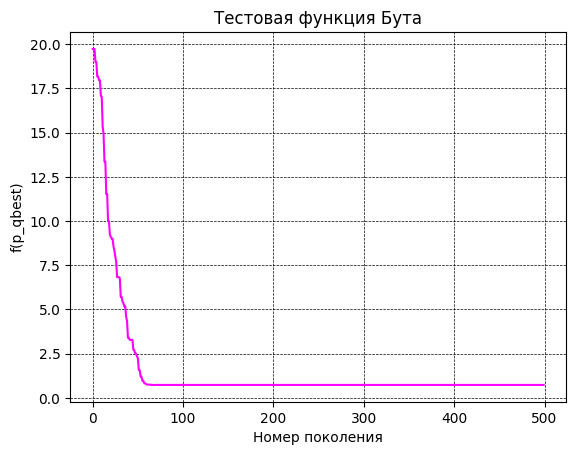

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.91263001 3.70869245]
The function value of pqbest:		0.3383147820489838
Algorithm running time:			0.018011093139648438 s


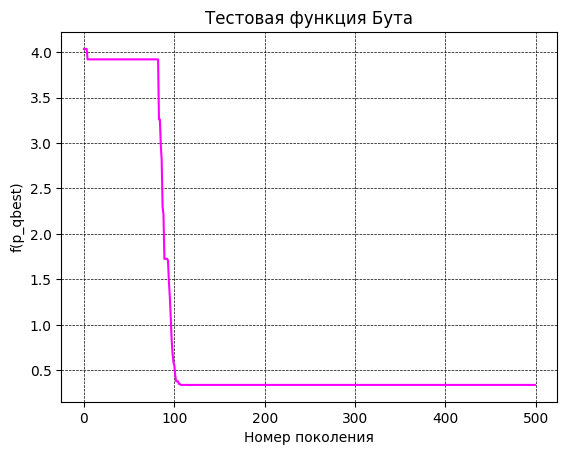

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.28198561 2.68575264]
The function value of pqbest:		0.07531415875070409
Algorithm running time:			0.01799607276916504 s


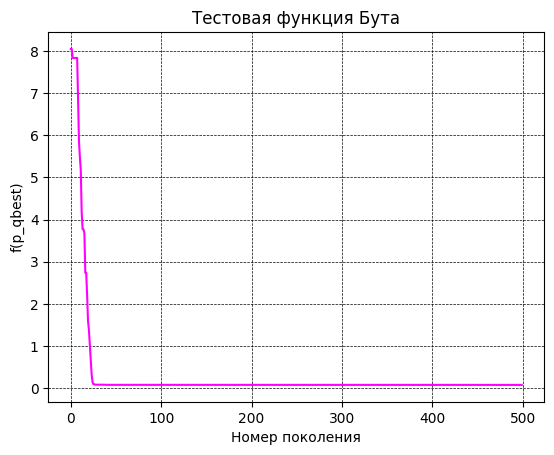

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.68918197 1.20561579]
The function value of pqbest:		2.7749996313738383
Algorithm running time:			0.01801753044128418 s


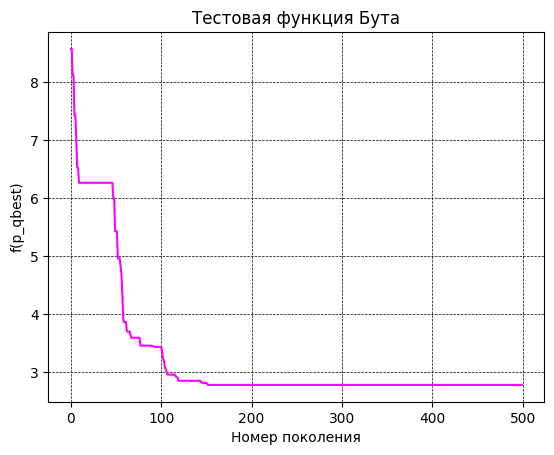

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[3.85064949 0.93274614]
The function value of pqbest:		13.23990362376966
Algorithm running time:			0.018021821975708008 s


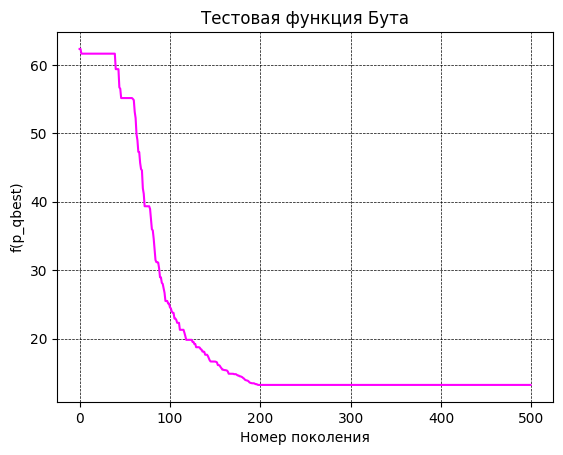

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.69642175 2.00687496]
The function value of pqbest:		0.19625101107760345
Algorithm running time:			0.018003463745117188 s


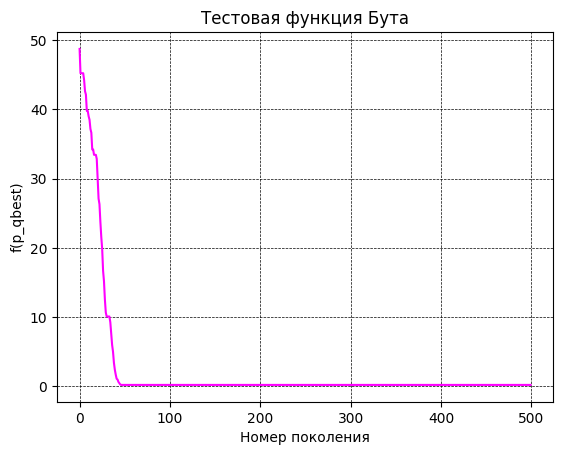

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[1.64976395 2.07206188]
The function value of pqbest:		0.16470472443196757
Algorithm running time:			0.01800370216369629 s


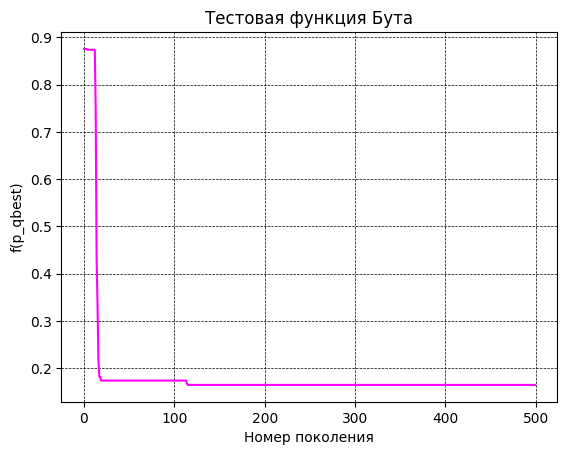

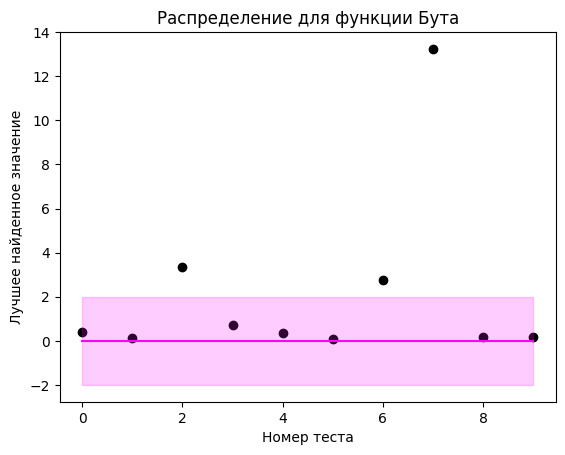

In [63]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_)